Recently I'm been playing bad used car salesman. Dangerous degen used cars in Deribit. Over the past few days of looking closely into the market microstructure and shifting option prices there seems to be some seasonal patterns playing out in that market. This notebook is my project in finding out if I can capture some of those effects in the data. So after playing with Deribit's API I got it to spit out ETH's Volatility Index from March 2021. Not much to work with here since it's only a bit more than a year so I'll concentrate on daily seasonality patterns then see if we can find any weekly seasonality patterns.

I'll be copying patterns from [intraday seasonality effects notebook](https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/7_Seasonality_Hour.ipynb).

In [ ]:
install.packages('tidyverse')
install.packages('lubridate')
install.packages('slider')
install.packages('tibbletime')
library(tidyverse)
library(lubridate)
library(slider)
library(tibbletime)


# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

* checking for file /tmp/RtmpXEhMzU/remotes4a694eddb5/RWLab-rwRtools-227fbb2/DESCRIPTION ... OK
* preparing rwRtools:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted LazyData from DESCRIPTION
* building rwRtools_0.1.20.tar.gz



Load Dvol and prepare data into what we need

In [ ]:
btc_vol <- read.csv(file = '/content/btc_dvol.csv')

btc_vol <- btc_vol %>% 
  mutate(datetime = ymd_hms(datetime),
          ticker = 'btc')

btc_vol %>% head()

,X...timestamp,open,high,low,close,datetime,ticker
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>
1,1.616544e+12,84.80,85.41,84.67,84.88,2021-03-24 00:00:00,btc
2,1.616548e+12,84.88,88.07,84.77,86.60,2021-03-24 01:00:00,btc
3,1.616551e+12,86.60,87.10,86.19,86.19,2021-03-24 02:00:00,btc
4,1.616555e+12,86.19,86.95,86.09,86.31,2021-03-24 03:00:00,btc
5,1.616558e+12,86.31,86.79,84.31,84.35,2021-03-24 04:00:00,btc
6,1.616562e+12,84.35,84.99,83.51,83.54,2021-03-24 05:00:00,btc


In [ ]:
eth_vol <- read.csv(file = '/content/eth_dvol.csv')

eth_vol <- eth_vol %>% 
  mutate(datetime = ymd_hms(datetime),
          ticker = 'eth')

eth_vol %>% head()

,X...timestamp,open,high,low,close,datetime,ticker
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>
1,1.616544e+12,94.18,94.30,93.68,93.86,2021-03-24 00:00:00,eth
2,1.616548e+12,93.86,94.65,93.77,94.35,2021-03-24 01:00:00,eth
3,1.616551e+12,94.35,97.26,94.25,94.65,2021-03-24 02:00:00,eth
4,1.616555e+12,94.65,95.07,94.54,95.07,2021-03-24 03:00:00,eth
5,1.616558e+12,95.07,95.07,94.16,94.18,2021-03-24 04:00:00,eth
6,1.616562e+12,94.18,94.38,93.39,93.41,2021-03-24 05:00:00,eth


In [ ]:
vol <- btc_vol %>%
  bind_rows(eth_vol) %>%
    arrange(datetime)

vol %>% 
    head()

,X...timestamp,open,high,low,close,datetime,ticker
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<chr>
1,1.616544e+12,84.80,85.41,84.67,84.88,2021-03-24 00:00:00,btc
2,1.616544e+12,94.18,94.30,93.68,93.86,2021-03-24 00:00:00,eth
3,1.616548e+12,84.88,88.07,84.77,86.60,2021-03-24 01:00:00,btc
4,1.616548e+12,93.86,94.65,93.77,94.35,2021-03-24 01:00:00,eth
5,1.616551e+12,86.60,87.10,86.19,86.19,2021-03-24 02:00:00,btc
6,1.616551e+12,94.35,97.26,94.25,94.65,2021-03-24 02:00:00,eth


Start by plotting. It sure looks quite stationary over time unlike underlying prices.

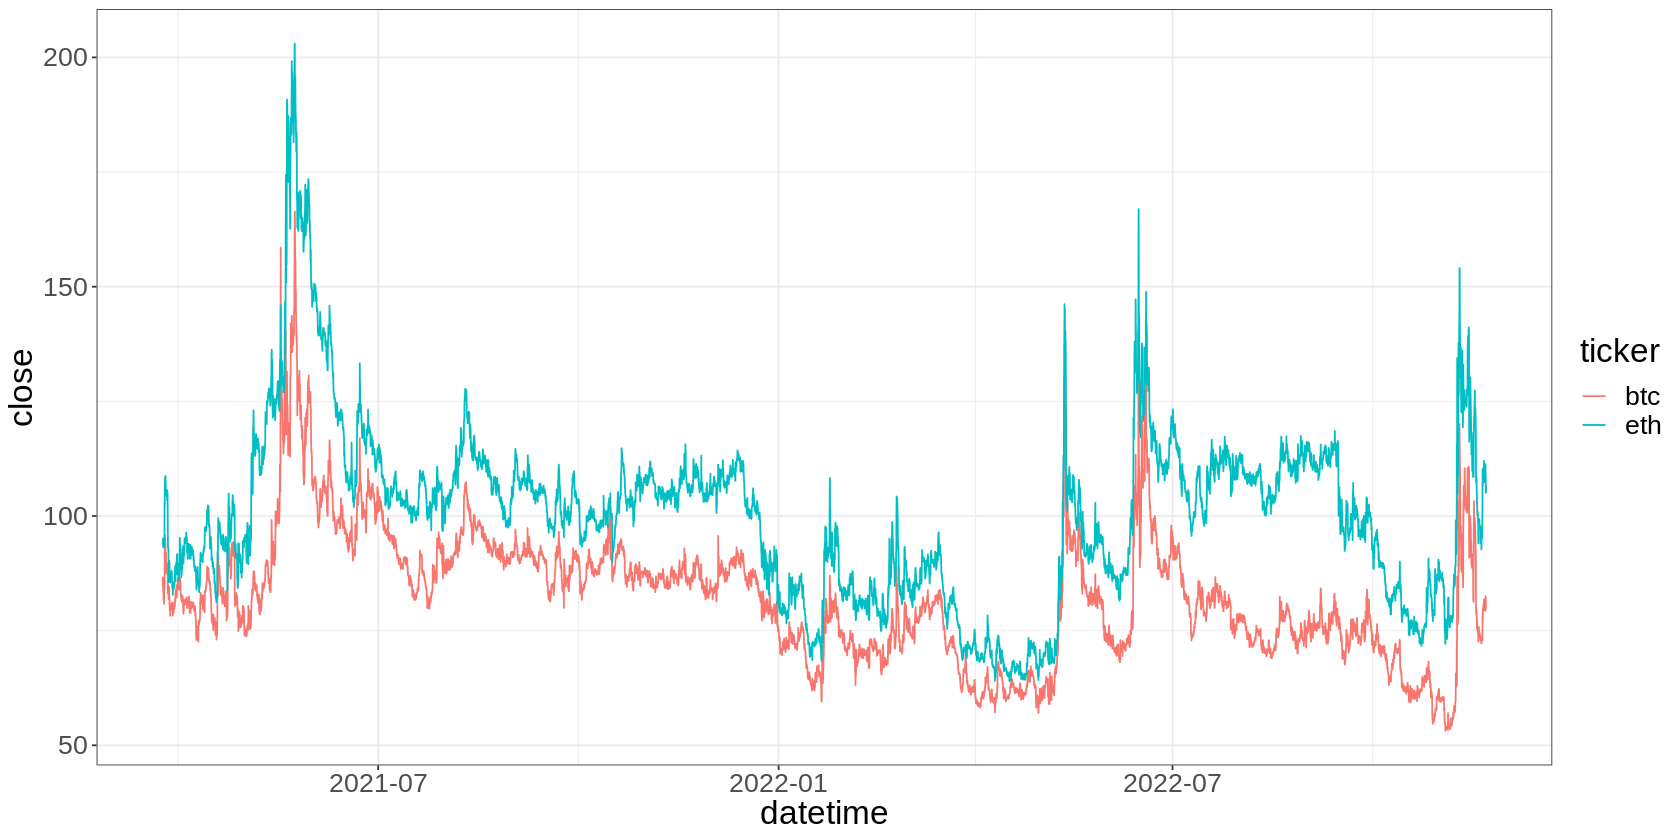

In [ ]:
vol %>% 
  ggplot(aes(x = datetime, y = close, color = ticker)) +
    geom_line()

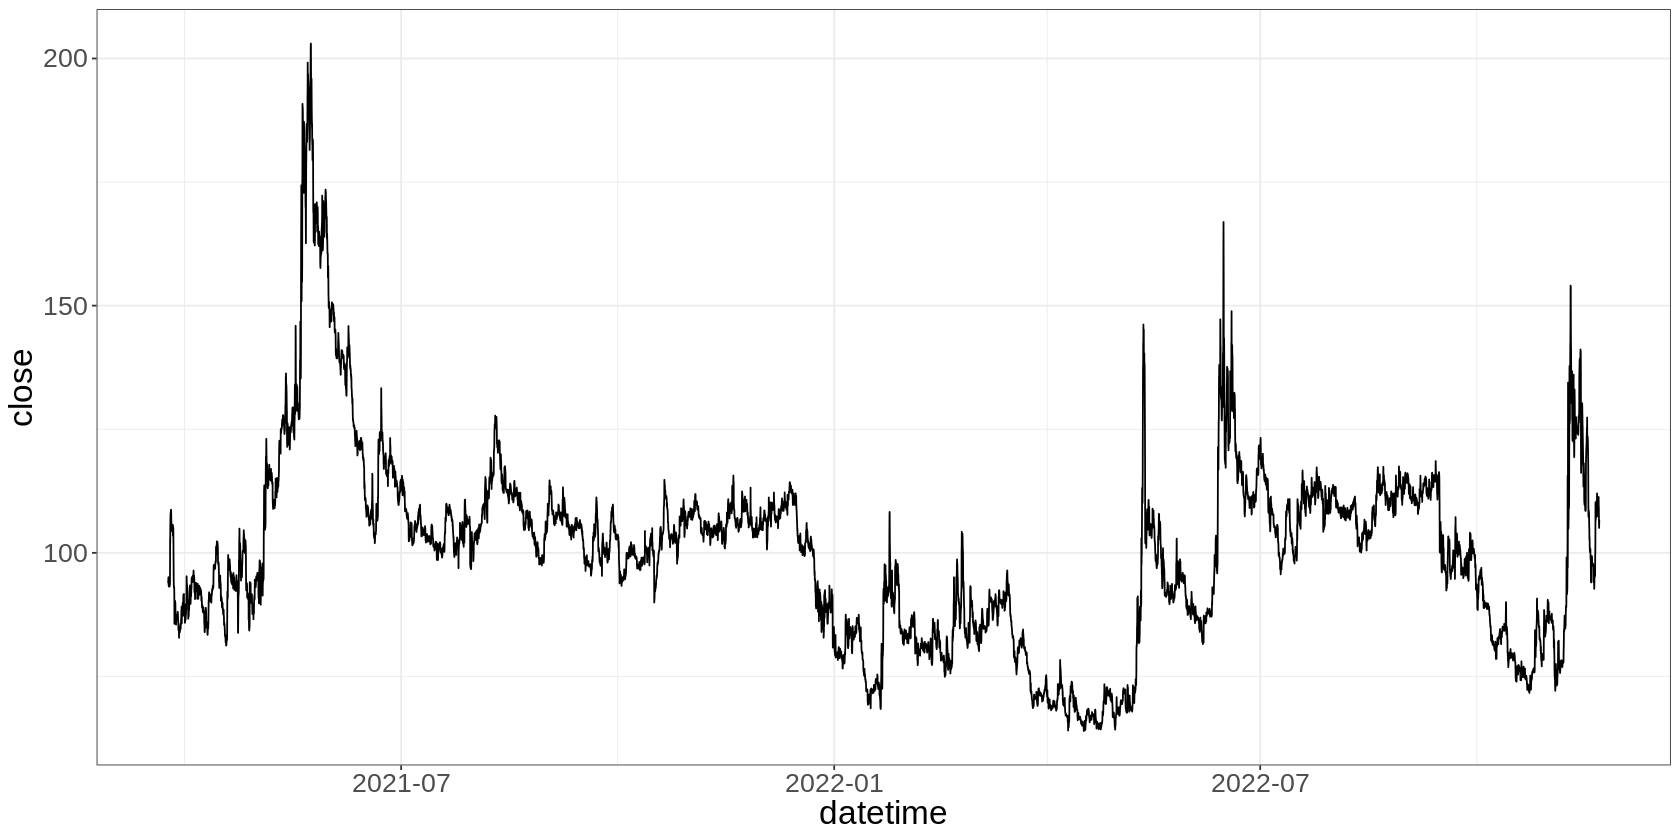

In [ ]:
eth_vol %>%
  ggplot(aes(x=datetime, y=close)) +
    geom_line()

# Hourly Seasonality

In [ ]:
hourly_seasonality <- eth_vol %>% 
  mutate(
    year = lubridate::year(datetime),
    month = lubridate::month(datetime),
    yearmonth = paste(year,'-', month),
    day = lubridate::day(datetime),
    hour = lubridate::hour(datetime),
    day_of_week = lubridate::wday(datetime), 
    c2c_logvol = log(close/lag(close)),
    logrange = log(high/low)
  ) %>%
  na.omit()

Now it's time to plot. Interesting that overnight dvol clearly drops. Then picks up as the Western Markets open.

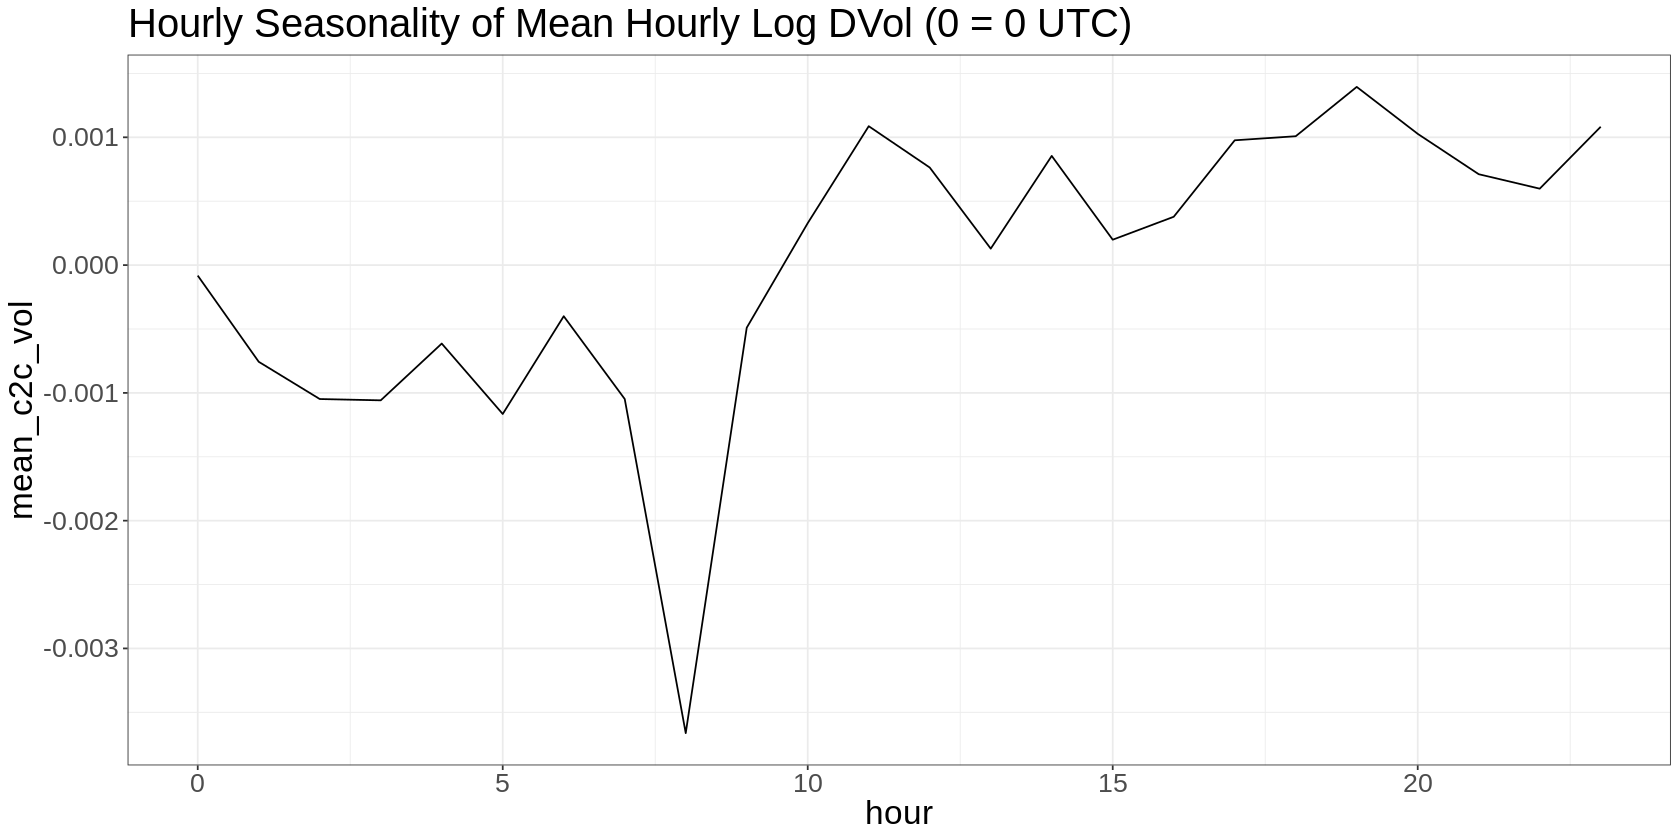

In [ ]:
hourly_seasonality %>%
  group_by(hour) %>%
  mutate(mean_c2c_vol = mean(c2c_logvol)) %>%
  ggplot(aes(x=hour, y=mean_c2c_vol)) +
  geom_line() +
  ggtitle('Hourly Seasonality of Mean Hourly Log DVol (0 = 0 UTC)')

Let's see how this holds up over the months since DVol is available. Not in chronological since I don't know how to get R to understand that "2021 - 10" is AFTER 2021 - 4". Hmm, they look quite different. Though there might be a noisy relationship.

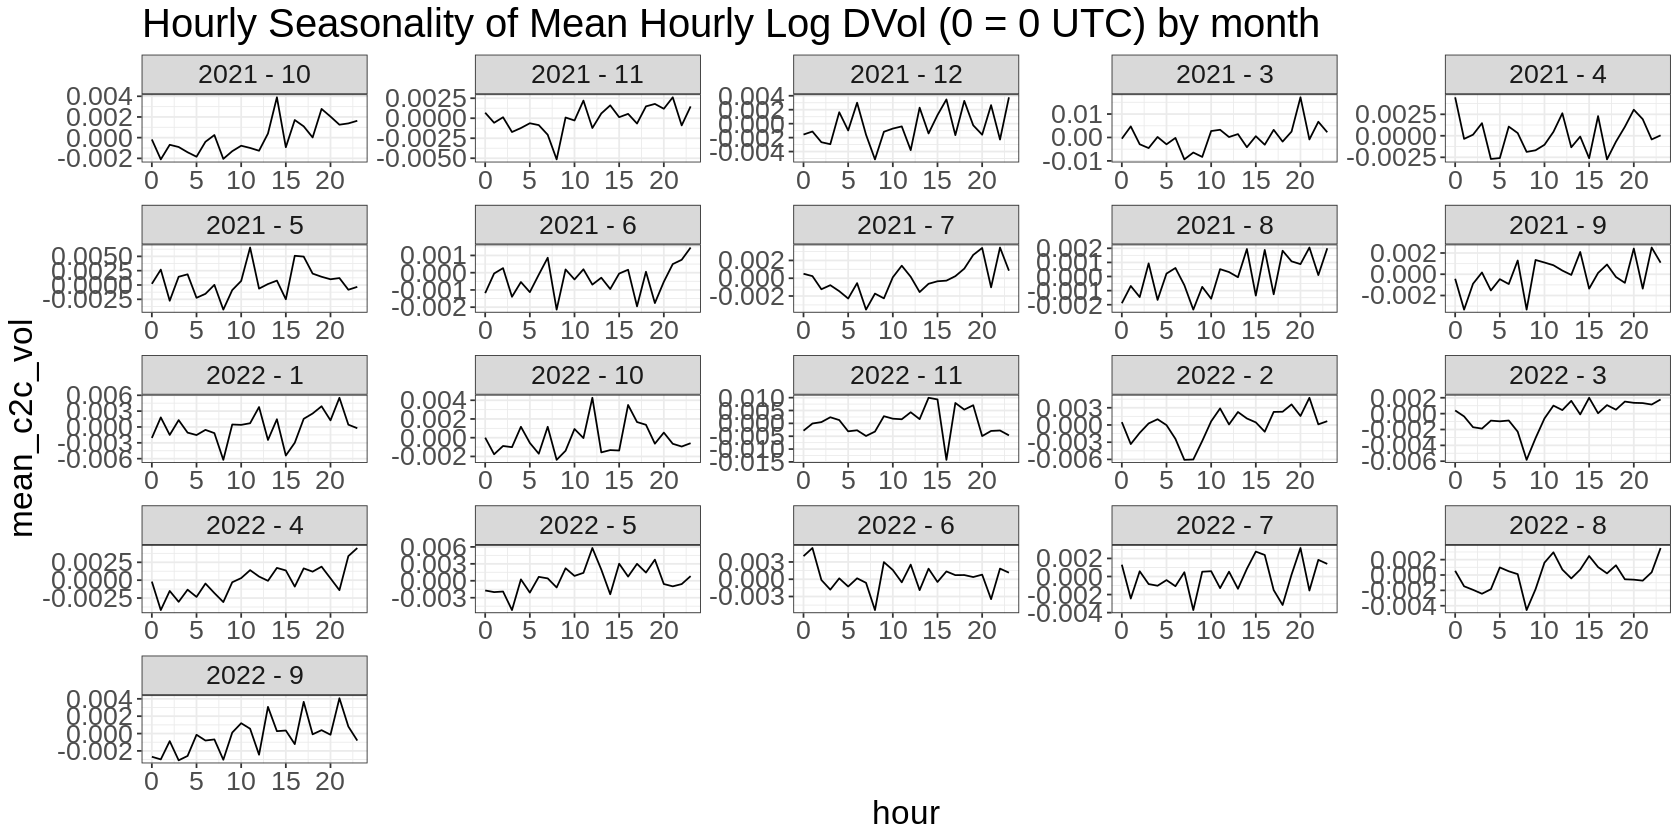

In [ ]:
hourly_seasonality %>%
  group_by(yearmonth, hour) %>%
  mutate(mean_c2c_vol = mean(c2c_logvol)) %>%
  ggplot(aes(x=hour, y=mean_c2c_vol)) +
  geom_line() +
  ggtitle('Hourly Seasonality of Mean Hourly Log DVol (0 = 0 UTC) by month') +
  facet_wrap(~yearmonth, scales='free')

Looking at only 2022, it's finally in chronological order. The overall shape looks like full data set. This is reassuring. Though plotting by month it looks like some months, while overall UTC 15 (let's call this US Market Opens) has strong positive mean vol, the recent months of Oct and Nov 2022 that hour has been strongly negative. 

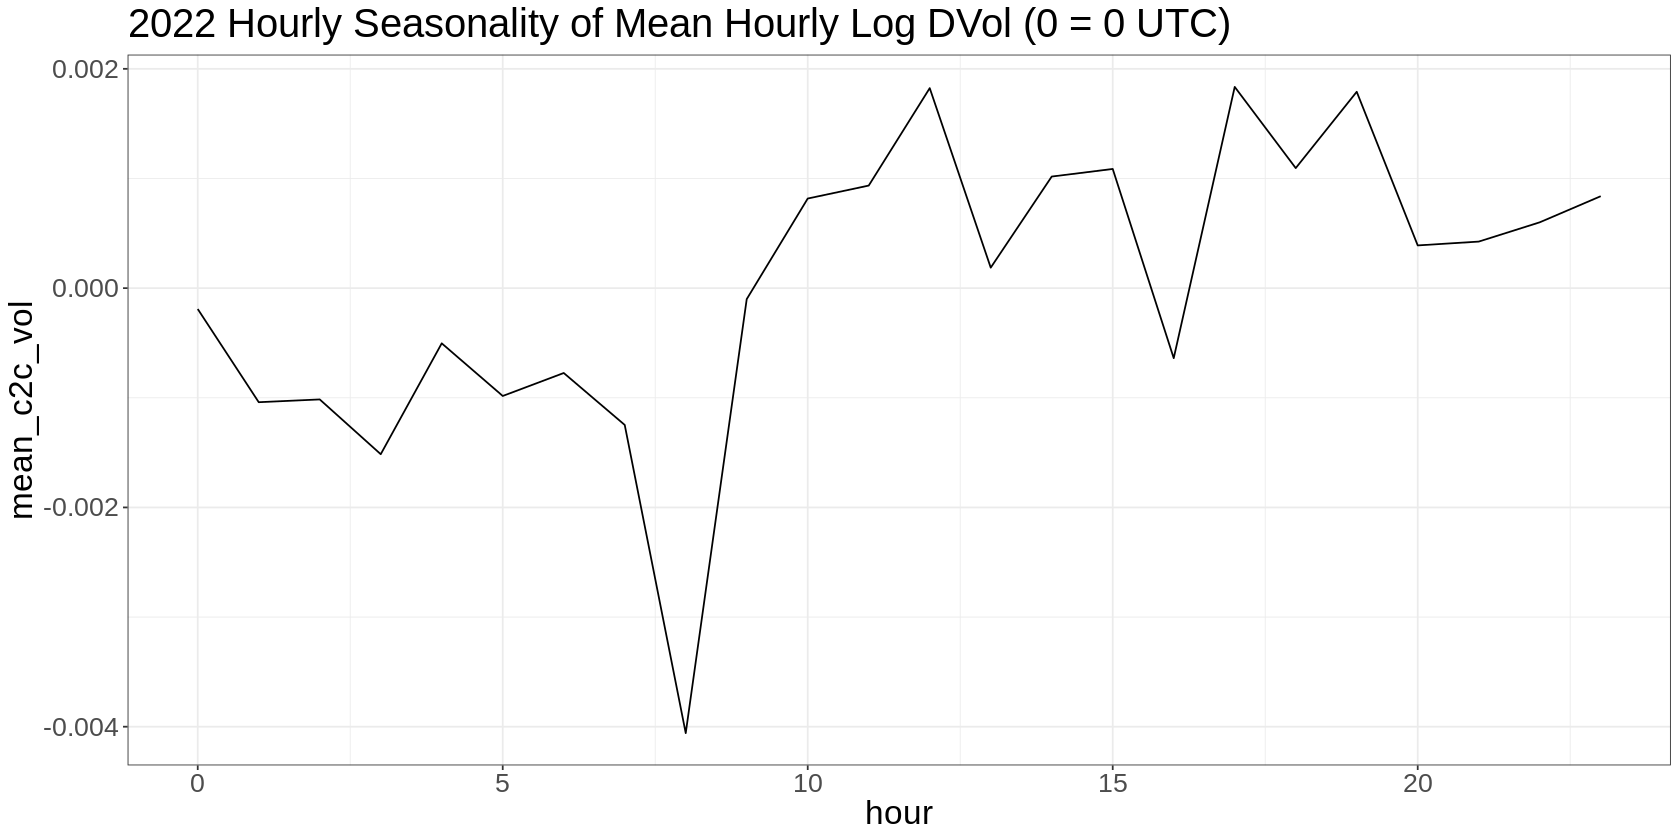

In [ ]:
hourly_seasonality %>%
  filter(year == '2022') %>%
  group_by(hour) %>%
  mutate(mean_c2c_vol = mean(c2c_logvol)) %>%
  ggplot(aes(x=hour, y=mean_c2c_vol)) +
  geom_line() +
  ggtitle('2022 Hourly Seasonality of Mean Hourly Log DVol (0 = 0 UTC)')

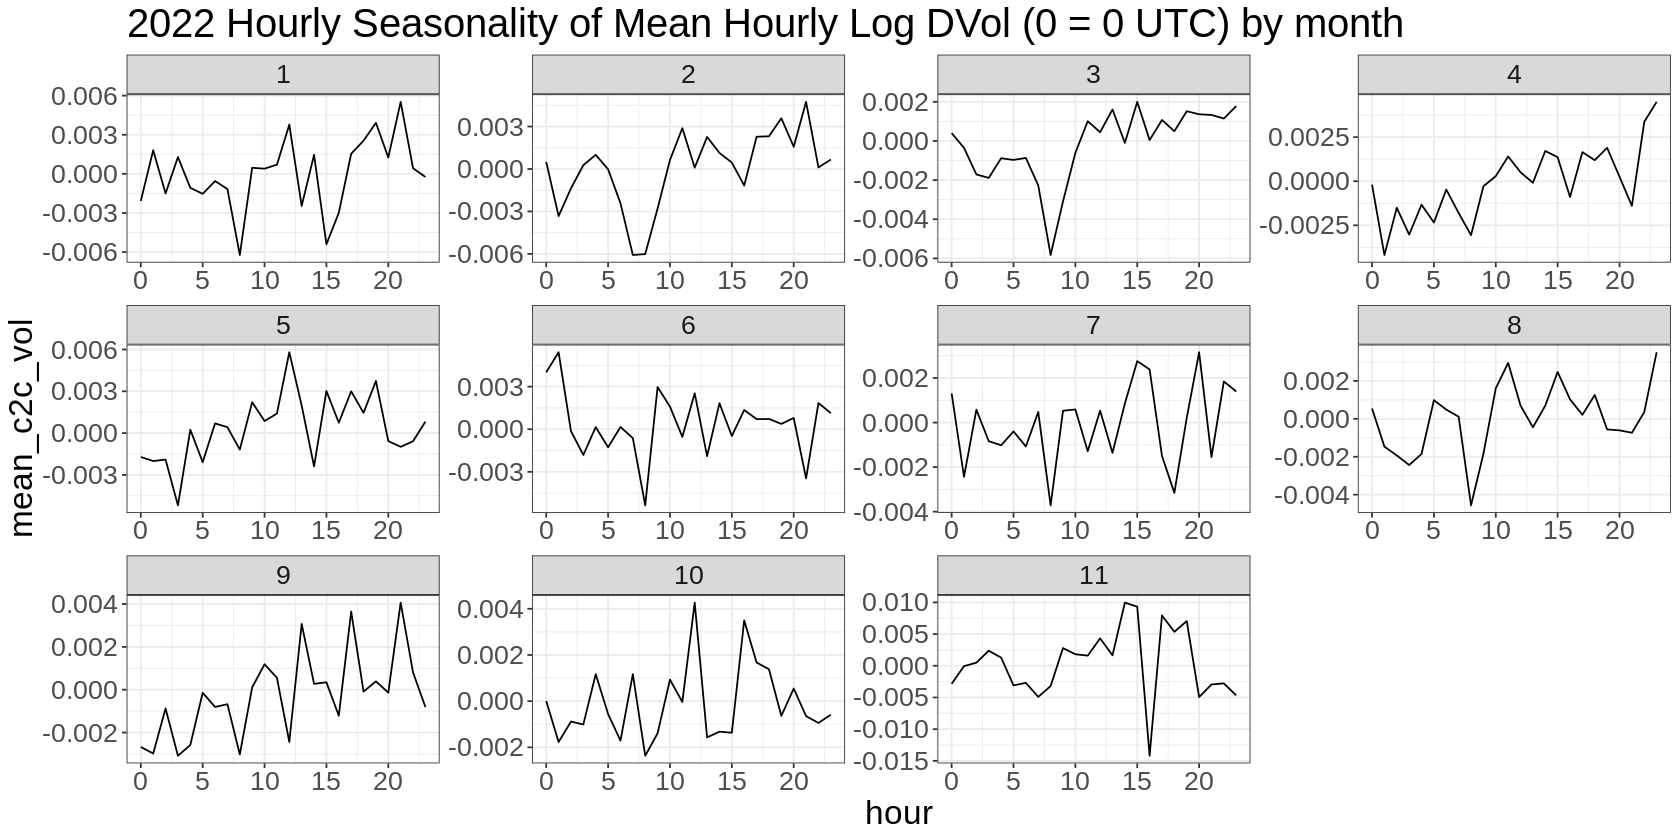

In [ ]:
hourly_seasonality %>%
  filter(year == '2022') %>%
  group_by(month, hour) %>%
  mutate(mean_c2c_vol = mean(c2c_logvol)) %>%
  ggplot(aes(x=hour, y=mean_c2c_vol)) +
  geom_line() +
  ggtitle('2022 Hourly Seasonality of Mean Hourly Log DVol (0 = 0 UTC) by month') +
  facet_wrap(~month, scales='free')

Well, looks like I've just scratched the surface of this vol data. It gives me heads up that I should be looking into other ways of presenting this info and also other sensible features to look at.

## Dumb Ape Vol Plots

Recall the [crypto hourly seasonality notebook](https://github.com/RWLab/crypto-pod/blob/main/research/7_Seasonality_Hour.ipynb), UTC 15 was noted to be the hour with the least volume. Makes sense that low volume is correlated with low volatility and that has relationship with low options IV. And that after US Market is in full swing that Dvol ramps up and then ramp down for the "overnight session".

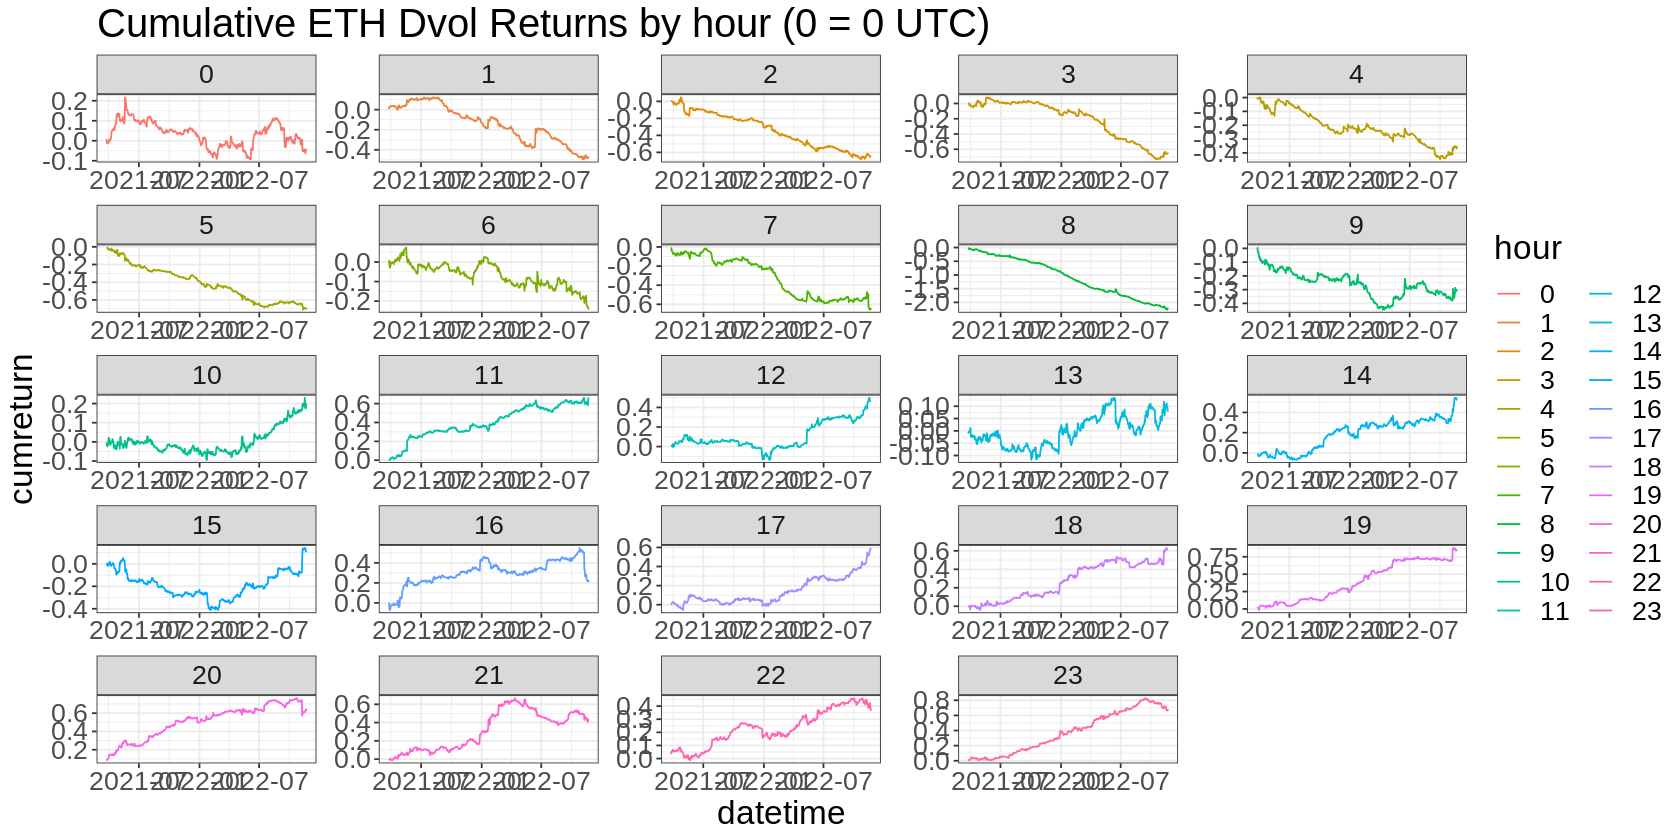

In [ ]:
hourly_seasonality %>%
  arrange(datetime) %>%
  mutate(
    hour = factor(lubridate::hour(datetime)), 
    c2c_logreturn = log(close/lag(close))
  ) %>%
  na.omit() %>%
  group_by(hour) %>%
  mutate(cumreturn = cumsum(c2c_logreturn)) %>%
  ggplot(aes(x=datetime, y=cumreturn, color=hour)) + 
    geom_line() +
    ggtitle('Cumulative ETH Dvol Returns by hour (0 = 0 UTC)') +
    facet_wrap(~hour, scales='free')

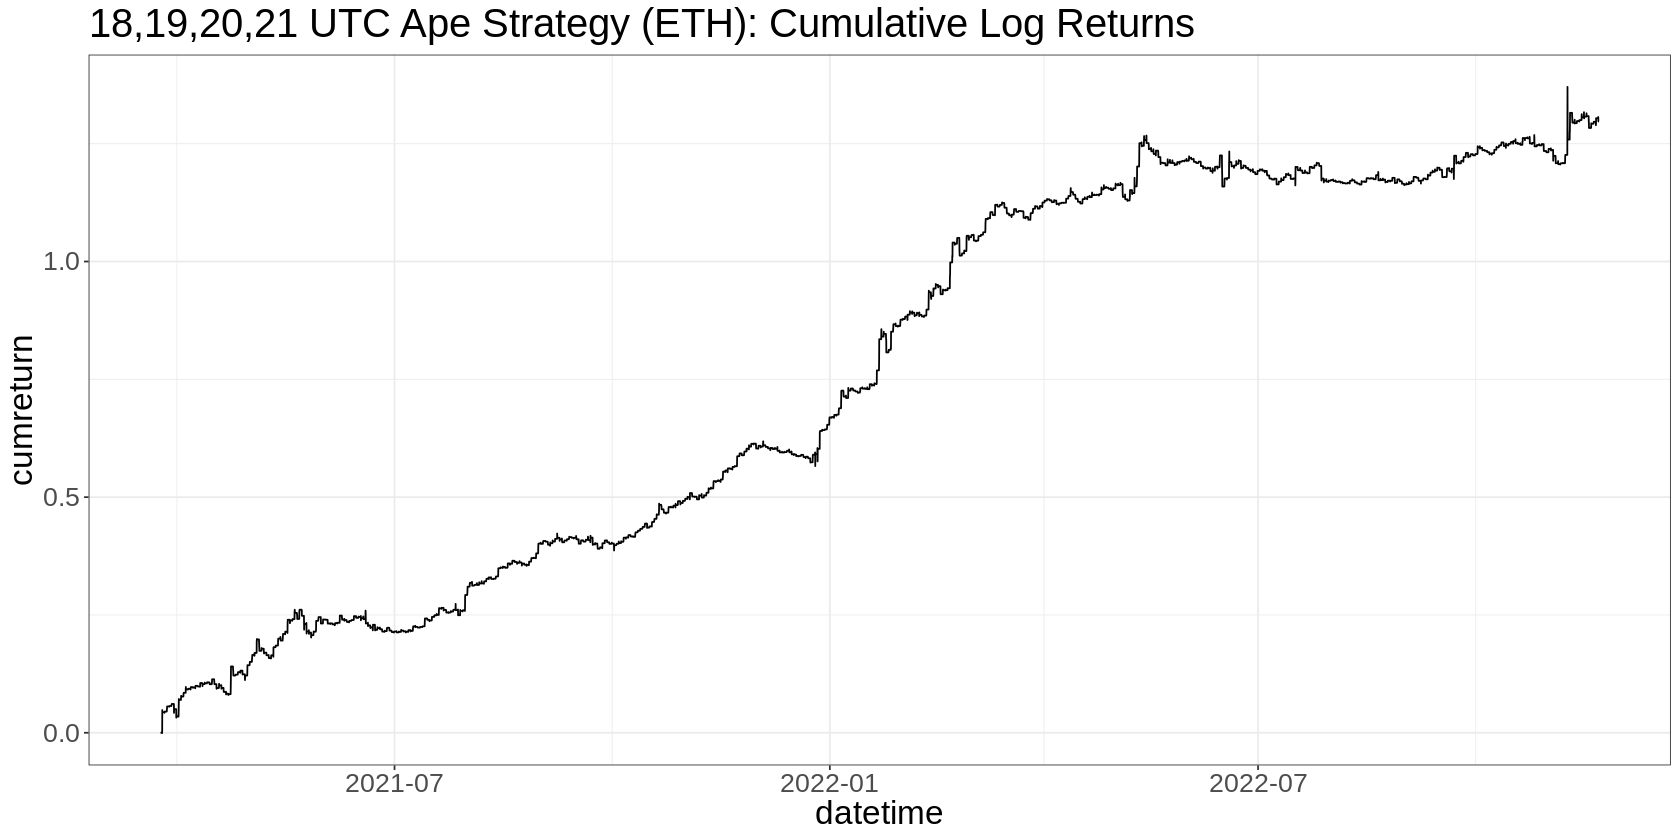

In [ ]:
hours <- c(18,19,20,21)

hourly_seasonality %>%
  arrange(datetime) %>%
  mutate(
    c2c_simplereturn = close / lag(close) - 1,
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  mutate(strat_return = case_when(hour %in% hours ~ c2c_simplereturn, TRUE ~ 0)) %>%
  group_by(datetime) %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(datetime) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=datetime, y=cumreturn)) +
    geom_line() +
    ggtitle('18,19,20,21 UTC Vol Ape Strategy (ETH): Cumulative Log Returns')

In [ ]:
hours <- c(12,13,14,15,16,17,18,19,20,21,22,23)

Long only 12h

In [ ]:
hourly_seasonality %>%
  arrange(datetime) %>%
  mutate(
    c2c_simplereturn = close / lag(close) - 1,
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  mutate(strat_return = case_when(hour %in% hours ~ c2c_simplereturn, TRUE ~ 0)) %>%
  group_by(datetime) %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(datetime) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=datetime, y=cumreturn)) +
    geom_line() +
    ggtitle('Half Day UTC Vol Ape Strategy (ETH): Cumulative Log Returns')

Short only 12h

In [ ]:
hourly_seasonality %>%
  arrange(datetime) %>%
  mutate(
    c2c_simplereturn = close / lag(close) - 1,
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  mutate(strat_return = case_when(hour %in% hours ~ 0, TRUE ~ -c2c_simplereturn)) %>%
  group_by(datetime) %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(datetime) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=datetime, y=cumreturn)) +
    geom_line() +
    ggtitle('Half Day UTC Vol Degen Sell Strategy (ETH): Cumulative Log Returns')

Long-Short each day

In [ ]:
hourly_seasonality %>%
  arrange(datetime) %>%
  mutate(
    c2c_simplereturn = close / lag(close) - 1,
    c2c_logreturn = log(close/lag(close)),
  ) %>%
  na.omit() %>%
  mutate(strat_return = case_when(hour %in% hours ~ c2c_simplereturn, TRUE ~ -c2c_simplereturn)) %>%
  group_by(datetime) %>%
  summarise(strat_logreturn = log(mean(strat_return / 2) + 1)) %>%
  arrange(datetime) %>%
  mutate(cumreturn = cumsum(strat_logreturn)) %>%
  ggplot(aes(x=datetime, y=cumreturn)) +
    geom_line() +
    ggtitle('Half Day UTC Vol Ape Strategy (ETH): Cumulative Log Returns')

# What's Next

I'm going over TLAQ's VRP Course and Euan Sinclair's books again. There's important pointers there. The consistent difference of "US session" and "ROW session" in markets that trade 24h might be applicable in simple trading strategies.